# MLflow Experiment Setup

In [3]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import joblib

# --- 1. Setup MLflow experiment ---
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("model_experiment")
print("MLflow experiment 'model_experiment' is set up and ready for tracking.")

2025/10/13 15:12:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/13 15:12:48 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/10/13 15:12:48 INFO mlflow.tracking.fluent: Experiment with name 'model_experiment' does not exist. Creating a new experiment.


MLflow experiment 'model_experiment' is set up and ready for tracking.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn import metrics
from utils import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
import seaborn

Load Data

In [6]:
df = pd.read_csv('./Vienthong.csv')
# Filter the DataFrame to keep only rows where the first column is "VGI"
vgi_data = df[df['code'] == 'VGI']
vgi_data = vgi_data[['date', 'close', 'open', 'high', 'low', 'nmVolume']]
# Print the filtered data
print(vgi_data)


            date  close  open  high   low   nmVolume
2     2021-12-03   33.4  35.0  35.2  33.4   478373.0
3     2021-12-09   32.5  32.2  32.6  31.8   442200.0
7     2021-12-14   33.1  33.1  33.6  32.5   287667.0
8     2021-12-15   32.5  32.9  32.9  32.4   298300.0
17    2021-12-21   32.5  32.6  32.8  32.4   329005.0
...          ...    ...   ...   ...   ...        ...
4262  2019-01-28   14.8  15.0  15.1  14.7    65045.0
4276  2019-03-05   22.0  23.2  23.2  21.5   496660.0
4277  2019-04-09   24.1  25.0  25.1  24.0   377035.0
4282  2019-05-15   25.7  25.7  26.3  25.3   695329.0
4283  2019-07-01   26.9  27.4  27.9  26.3  1071222.0

[821 rows x 6 columns]


In [7]:
# Check duplicates
vgi_data.duplicated().sum()

np.int64(0)

In [8]:
data = vgi_data
data.index = pd.to_datetime(data['date'], format='%Y-%m-%d') 
data.sort_index(inplace=True)
data = data.drop(['date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

In [9]:
data.head()

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 821 entries, 2018-09-25 to 2021-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   close     821 non-null    float64
 1   open      821 non-null    float64
 2   high      821 non-null    float64
 3   low       821 non-null    float64
 4   nmVolume  821 non-null    float64
dtypes: float64(5)
memory usage: 38.5 KB


Pre-processing

In [11]:
d = data.asfreq(freq='B', fill_value=np.nan) #B stand for business day excluding saturday and sunday
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854 entries, 2018-09-25 to 2021-12-31
Freq: B
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   close     821 non-null    float64
 1   open      821 non-null    float64
 2   high      821 non-null    float64
 3   low       821 non-null    float64
 4   nmVolume  821 non-null    float64
dtypes: float64(5)
memory usage: 40.0 KB


In [12]:
d.isna().sum()

close       33
open        33
high        33
low         33
nmVolume    33
dtype: int64

In [13]:
nan_rows = d[d.isna().any(axis=1)]
nan_rows.head()

,close,open,high,low,nmVolume
date,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,NaN
2019-02-04,NaN,NaN,NaN,NaN,NaN
2019-02-05,NaN,NaN,NaN,NaN,NaN
2019-02-06,NaN,NaN,NaN,NaN,NaN


In [14]:
# Extract the day name from the date
day_name = nan_rows.index.strftime('%A')
day_name.unique()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], dtype='object', name='date')

In [15]:
nan_rows['day_name'] = day_name
nan_rows.head()

C:\Users\mayssen\AppData\Local\Temp\ipykernel_21144\1872831587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows['day_name'] = day_name


,close,open,high,low,nmVolume,day_name
date,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,Monday
2019-01-01,NaN,NaN,NaN,NaN,NaN,Tuesday
2019-02-04,NaN,NaN,NaN,NaN,NaN,Monday
2019-02-05,NaN,NaN,NaN,NaN,NaN,Tuesday
2019-02-06,NaN,NaN,NaN,NaN,NaN,Wednesday


In [16]:
grouped = nan_rows.groupby('day_name')

# Iterate over each group and print the group value
for group_value, group_data in grouped:
    print(group_value)
    print('#'*30)
    print(group_data.head(5))
    print('Number of days: ', group_data.shape[0])

Friday
##############################
            close  open  high  low  nmVolume day_name
date                                                 
2019-02-08    NaN   NaN   NaN  NaN       NaN   Friday
2020-01-24    NaN   NaN   NaN  NaN       NaN   Friday
2020-05-01    NaN   NaN   NaN  NaN       NaN   Friday
2021-01-01    NaN   NaN   NaN  NaN       NaN   Friday
2021-02-12    NaN   NaN   NaN  NaN       NaN   Friday
Number of days:  7
Monday
##############################
            close  open  high  low  nmVolume day_name
date                                                 
2018-12-31    NaN   NaN   NaN  NaN       NaN   Monday
2019-02-04    NaN   NaN   NaN  NaN       NaN   Monday
2019-04-15    NaN   NaN   NaN  NaN       NaN   Monday
2019-04-29    NaN   NaN   NaN  NaN       NaN   Monday
2019-09-02    NaN   NaN   NaN  NaN       NaN   Monday
Number of days:  8
Thursday
##############################
            close  open  high  low  nmVolume  day_name
date                               

In [17]:
d = d.interpolate(method='linear')
d.isna().sum()

close       0
open        0
high        0
low         0
nmVolume    0
dtype: int64

In [18]:
d.head()

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0


Save Dataset after Pre-processing

In [19]:
d.to_csv('vgi2.csv')

In [20]:
d = pd.read_csv('./vgi2.csv')

In [21]:
d

,date,close,open,high,low,nmVolume
0,2018-09-25,21.0,21.0,21.0,16.0,1816800.0
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...,...
849,2021-12-27,32.4,31.7,32.8,31.7,289274.0
850,2021-12-28,31.9,32.4,32.8,31.8,235860.0
851,2021-12-29,31.8,32.0,32.0,31.6,243603.0
852,2021-12-30,31.8,31.6,32.0,31.6,216170.0


In [22]:
d.index = pd.to_datetime(d['date'], format='%Y-%m-%d') 
d.sort_index(inplace=True)
d = d.drop(['date'], axis=1)
d = pd.DataFrame(d, dtype=np.float64)

In [23]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
close,854.0,28.780211,6.714127,12.0,25.200,28.30,32.90,47.5
open,854.0,28.765222,6.710119,12.0,25.100,28.35,33.00,47.5
high,854.0,29.377869,6.830721,12.3,25.725,28.80,33.50,48.8
low,854.0,28.137763,6.578820,11.3,24.525,27.90,32.20,46.0
nmVolume,854.0,575750.795082,468565.657151,19385.0,273129.750,446001.50,740738.25,3925002.0


In [24]:
features = list(d.select_dtypes(include = np.number).columns)
features

['close', 'open', 'high', 'low', 'nmVolume']

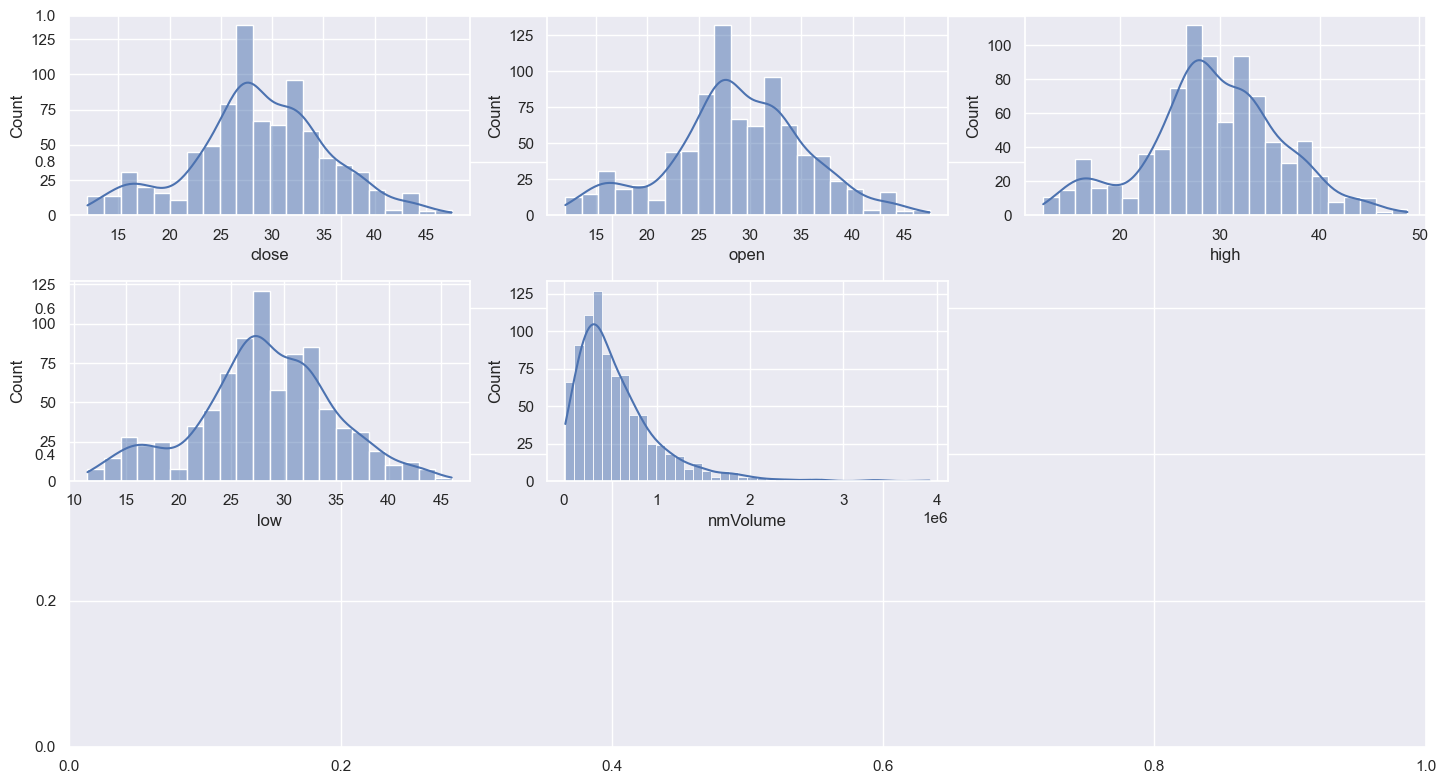

In [25]:
import seaborn as sns


sns.set_theme()

plt.subplots(figsize=(15,8))

for i, col in enumerate(features):  
  plt.subplot(3,3, i + 1)
  sns.histplot(d[col], kde=True)
  
plt.tight_layout()
plt.show()

In [26]:
from pandas import Grouper
from pandas import concat
from pandas import DataFrame

# Function for visualize box plot group by month in a specific year
def year_box_plot(data, y, code):
  one_year = data[data.index.year==y]
  groups = one_year.groupby(Grouper(freq='M'))

  months = concat([DataFrame(x[1].values) for x in groups], axis=1)
  months = DataFrame(months)
  months.columns = range(1,13)
  plt.figure(figsize=(20,8))
  months.boxplot()
  plt.xlabel('Month', size=20)
  plt.ylabel('Closed Price', size = 20)
  plt.title('Box and Whisker Plots by Month in year {} of {} code'.format(y,code), size=20)
  plt.show()

C:\Users\mayssen\AppData\Local\Temp\ipykernel_21144\33136132.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  groups = one_year.groupby(Grouper(freq='M'))


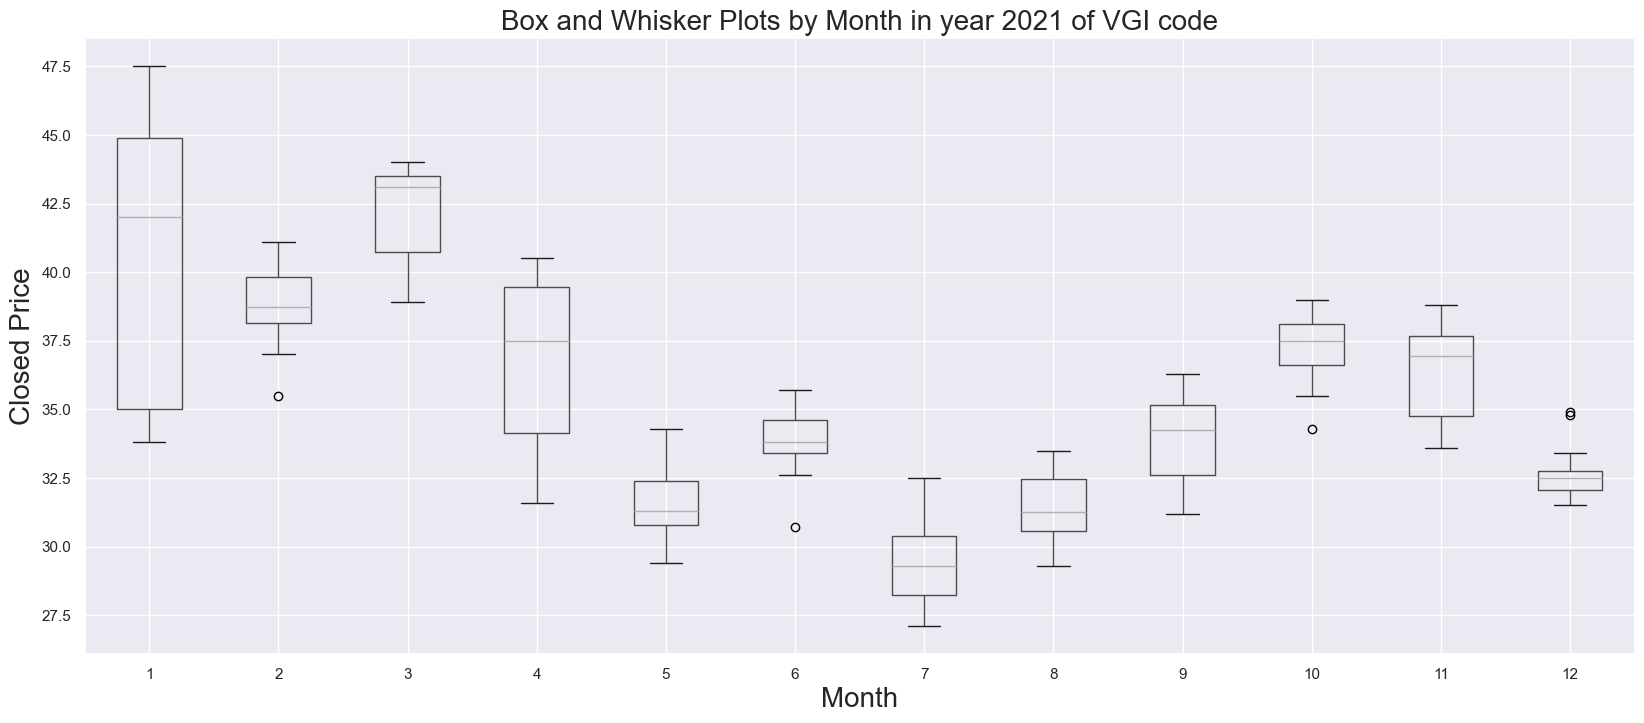

In [27]:
year_box_plot(d['close'], 2021, 'VGI')

In [28]:
from pandas import concat


def lag_plot(data):
  values = DataFrame(data.values)
  lags = 7
  columns = [values]
  for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
  dataframe = concat(columns, axis=1)
  columns = ['t']
  for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
  dataframe.columns = columns
  plt.figure(figsize=(20,8))

  for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)

  plt.show()

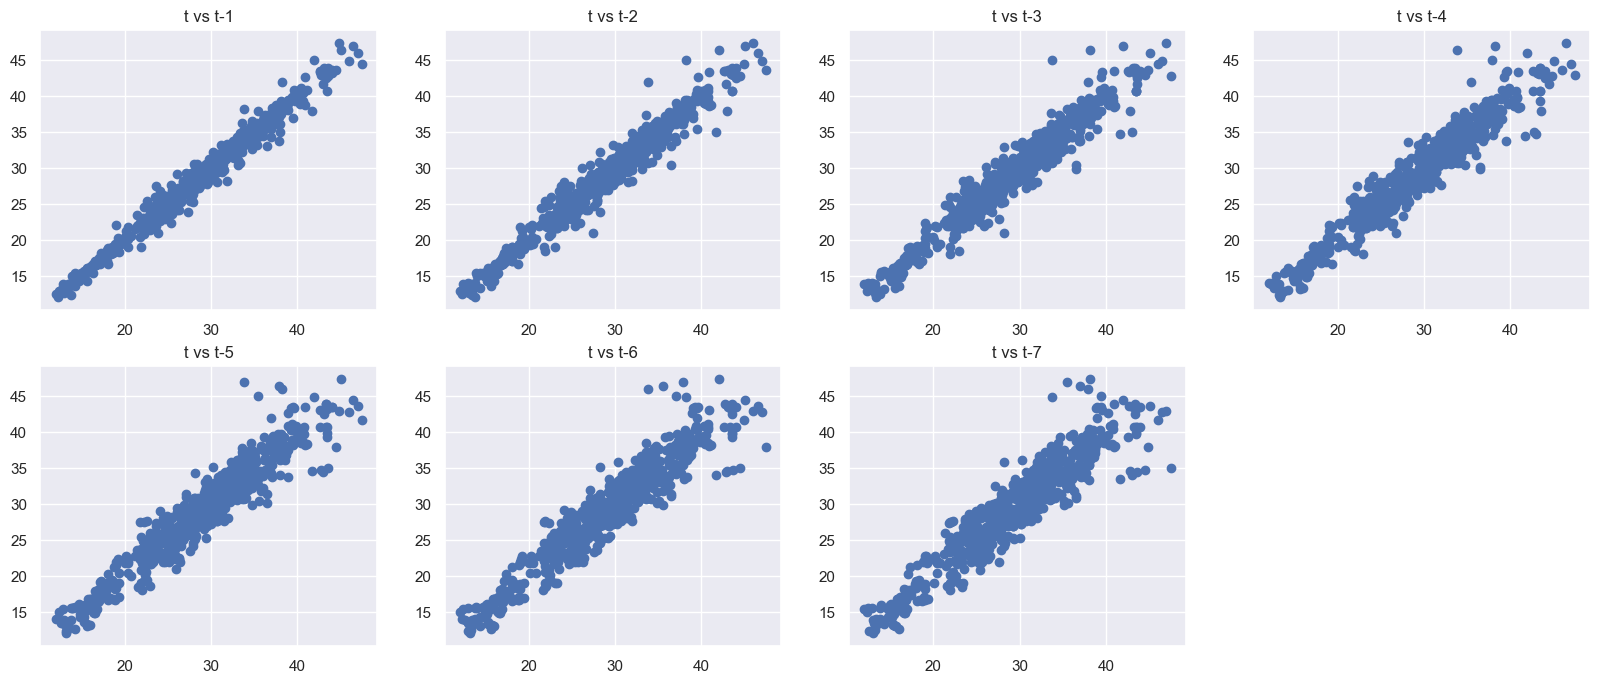

In [29]:
lag_plot(d['close'])

Split from the Dataset into Traing_set and Test_set (last two months). Training_set is split into train and validation (30% traning_set)

In [30]:
# Get the maximum date value
max_date = d.index.max()
print('max date:', max_date)
# Calculate the starting date for the last two months
start_date = max_date - pd.DateOffset(months=2)
print('start_date of last 2 months:', start_date)
print('pd.DateOffset(months=2)', pd.DateOffset(months=2))
# Filter the DataFrame for the last two months
last_two_months_data = d[d.index >= start_date]

# Print the last two months' data
print(last_two_months_data.head())

max date: 2021-12-31 00:00:00
start_date of last 2 months: 2021-10-31 00:00:00
pd.DateOffset(months=2) <DateOffset: months=2>
            close  open  high   low   nmVolume
date                                          
2021-11-01   38.7  39.1  39.8  38.5  1240132.0
2021-11-02   38.8  38.7  39.4  38.0  1602069.0
2021-11-03   37.5  38.8  39.0  37.5  1490049.0
2021-11-04   37.9  37.5  37.9  37.3   741502.0
2021-11-05   37.7  37.9  38.4  37.5   706210.0


In [31]:
test_set = last_two_months_data
test_set.shape

(45, 5)

In [32]:
test_set.to_csv('test_set.csv')

In [33]:
training_set= d[d.index < start_date]
training_set.shape


(809, 5)

In [34]:
training_set.to_csv('training_set.csv')

In [35]:
training_set

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0
2021-10-26,37.4,36.9,37.8,36.6,727721.0
2021-10-27,37.5,37.4,37.9,37.3,752737.0


In [36]:
test_set

,close,open,high,low,nmVolume
date,,,,,
2021-11-01,38.7,39.1,39.8,38.5,1240132.0
2021-11-02,38.8,38.7,39.4,38.0,1602069.0
2021-11-03,37.5,38.8,39.0,37.5,1490049.0
2021-11-04,37.9,37.5,37.9,37.3,741502.0
2021-11-05,37.7,37.9,38.4,37.5,706210.0
2021-11-08,37.7,37.5,38.0,37.2,952340.0
2021-11-09,37.6,37.5,37.9,37.3,821840.0
2021-11-10,37.3,37.6,37.9,37.2,690836.0
2021-11-11,36.6,37.4,37.5,36.3,1524668.0


In [37]:
def split_train_valid(train_data, valid_percent=0.3):
  lend = train_data.index.size
  spv = int(lend - valid_percent*lend)
  dpv = train_data.index[spv].strftime('%Y-%m-%d')
  print("Start date point validation:", dpv)
  train = train_data.iloc[:spv, :]
  valid = train_data.iloc[spv:, :]
  return train, valid

In [38]:
train, valid = split_train_valid(training_set)

Start date point validation: 2020-11-25


In [39]:
train.to_csv('train.csv')

In [40]:
valid.to_csv('valid.csv')

In [41]:
train

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2020-11-18,27.7,28.0,28.2,27.6,286298.0
2020-11-19,28.0,27.8,28.0,27.7,334025.0
2020-11-20,29.7,28.0,30.0,28.0,2780883.0


In [42]:
valid

,close,open,high,low,nmVolume
date,,,,,
2020-11-25,30.7,31.7,32.0,30.6,1250785.0
2020-11-26,30.7,30.5,30.8,30.1,826967.0
2020-11-27,31.3,30.5,31.9,29.8,947845.0
2020-11-30,30.9,31.3,31.4,30.8,709841.0
2020-12-01,31.4,30.3,31.5,29.8,1235551.0
...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0
2021-10-26,37.4,36.9,37.8,36.6,727721.0
2021-10-27,37.5,37.4,37.9,37.3,752737.0


In [43]:
print('train shape:', train.shape) # 2018-09-25 --> 2020-11-24
print('valid shape:', valid.shape) # 2020-11-25 --> 2021-10-29
print('test shape:', test_set.shape) #2021-11-01 --> 2021-12-31

train shape: (566, 5)
valid shape: (243, 5)
test shape: (45, 5)


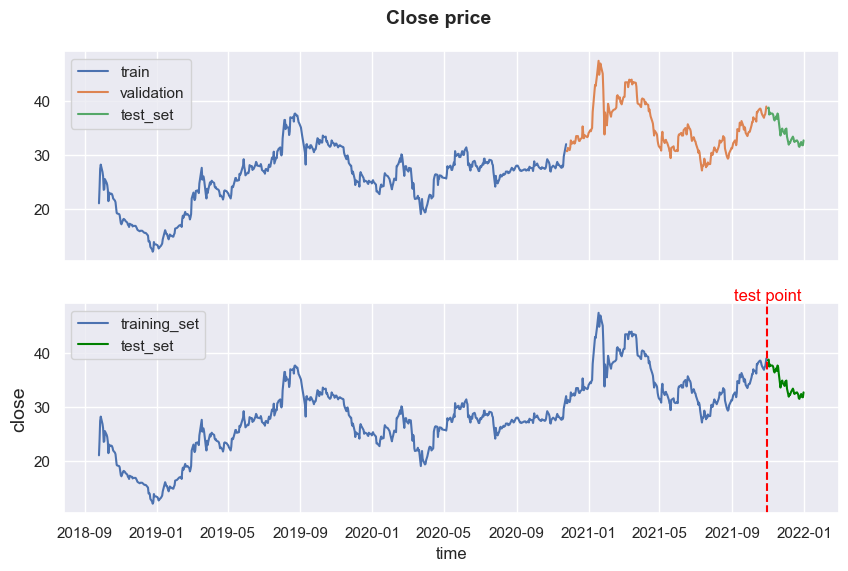

In [44]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 6))
# plt.figure(figsize=(10, 6))

ax[0].plot(train['close'], label='train')
ax[0].plot(valid['close'], label='validation')
ax[0].plot(test_set['close'], label='test_set')
ax[1].plot(training_set['close'], label='training_set')
ax[1].plot(test_set['close'], label='test_set', color='green')

# test point 
test_point = start_date
# Plot the vertical line
ax[1].axvline(x=test_point, color='red', linestyle='--')
# Add a text annotation for the vertical line
plt.text(test_point, ax[1].get_ylim()[1] + 0.5, 'test point', color='red', ha='center')

# plt.title('Close price')
fig.suptitle('Close price', fontsize=14, fontweight='bold', y=0.95)
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
ax[0].legend()
ax[1].legend()

plt.show()

In [45]:
print('train shape: ', training_set.shape)
print('test shape: ', test_set.shape)


train shape:  (809, 5)
test shape:  (45, 5)


In [46]:
print('Last date of training_set', training_set.iloc[-1].name)
print('% test: ', test_set.shape[0]/(test_set.shape[0]+training_set.shape[0])*100, '%')

Last date of training_set 2021-10-29 00:00:00
% test:  5.269320843091335 %


Building Model

#1. Persistence Model

##Validation

In [47]:
# evaluate a persistence model

# walk-forward validation
history = [x for x in train['close']]
predictions = list()
for i in range(valid.shape[0]):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = valid.iloc[i, 0] # 0 là vị trị của close
    history.append(obs)
    print(i+1, 'predicted=%f, expected=%f' % (yhat, obs))

# report performance
evaluation_metric(valid['close'],predictions)

# GetMAPE(y_hat, y_test):
mape_persitence = GetMAPE(predictions, valid['close'])
print('mape_persitence : %.3f' % mape_persitence, '%' )

1 predicted=32.000000, expected=30.700000
2 predicted=30.700000, expected=30.700000
3 predicted=30.700000, expected=31.300000
4 predicted=31.300000, expected=30.900000
5 predicted=30.900000, expected=31.400000
6 predicted=31.400000, expected=32.700000
7 predicted=32.700000, expected=32.300000
8 predicted=32.300000, expected=32.100000
9 predicted=32.100000, expected=32.500000
10 predicted=32.500000, expected=32.100000
11 predicted=32.100000, expected=32.200000
12 predicted=32.200000, expected=32.700000
13 predicted=32.700000, expected=33.500000
14 predicted=33.500000, expected=33.500000
15 predicted=33.500000, expected=32.900000
16 predicted=32.900000, expected=32.600000
17 predicted=32.600000, expected=32.600000
18 predicted=32.600000, expected=32.900000
19 predicted=32.900000, expected=33.200000
20 predicted=33.200000, expected=35.300000
21 predicted=35.300000, expected=34.000000
22 predicted=34.000000, expected=33.100000
23 predicted=33.100000, expected=33.700000
24 predicted=33.7000

## MLflow Tracking: Persistence Model

In [48]:
# Log Persistence Model (Baseline) to MLflow
with mlflow.start_run(run_name="Persistence_Model") as run:
    # Log parameters
    mlflow.log_param("model_type", "persistence")
    mlflow.log_param("strategy", "last_value")
    
    # Calculate validation metrics
    val_mse = metrics.mean_squared_error(valid['close'], predictions)
    val_rmse = np.sqrt(val_mse)
    val_mae = metrics.mean_absolute_error(valid['close'], predictions)
    val_r2 = metrics.r2_score(valid['close'], predictions)
    
    # Log validation metrics
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_metric("val_mape", mape_persitence)
    
    print(f"✅ Persistence Model (Validation) logged to MLflow - Run ID: {run.info.run_id}")

✅ Persistence Model (Validation) logged to MLflow - Run ID: 4be7682dc8974bbeb9b6ca41ec9e31f3


##Test

In [49]:
# evaluate a persistence model

# walk-forward test
history = [x for x in training_set['close']]
predictions = list()
for i in range(test_set.shape[0]):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test_set.iloc[i, 0] # 0 là vị trị của close
    history.append(obs)
    print(i+1, 'predicted=%f, expected=%f' % (yhat, obs))

# report performance
evaluation_metric(test_set['close'],predictions)

# GetMAPE(y_hat, y_test):
mape_persitence_test = GetMAPE(predictions, test_set['close'])
print('mape_persitence_test : %.3f' % mape_persitence_test, '%' )

1 predicted=39.000000, expected=38.700000
2 predicted=38.700000, expected=38.800000
3 predicted=38.800000, expected=37.500000
4 predicted=37.500000, expected=37.900000
5 predicted=37.900000, expected=37.700000
6 predicted=37.700000, expected=37.700000
7 predicted=37.700000, expected=37.600000
8 predicted=37.600000, expected=37.300000
9 predicted=37.300000, expected=36.600000
10 predicted=36.600000, expected=36.400000
11 predicted=36.400000, expected=37.200000
12 predicted=37.200000, expected=36.700000
13 predicted=36.700000, expected=37.700000
14 predicted=37.700000, expected=37.400000
15 predicted=37.400000, expected=36.300000
16 predicted=36.300000, expected=33.600000
17 predicted=33.600000, expected=34.600000
18 predicted=34.600000, expected=34.600000
19 predicted=34.600000, expected=34.900000
20 predicted=34.900000, expected=34.400000
21 predicted=34.400000, expected=33.900000
22 predicted=33.900000, expected=34.700000
23 predicted=34.700000, expected=34.800000
24 predicted=34.8000

In [50]:
# Log Persistence Model Test metrics to the same run
with mlflow.start_run(run_name="Persistence_Model") as run:
    # Log parameters
    mlflow.log_param("model_type", "persistence")
    mlflow.log_param("strategy", "last_value")
    
    # Calculate test metrics
    test_mse = metrics.mean_squared_error(test_set['close'], predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = metrics.mean_absolute_error(test_set['close'], predictions)
    test_r2 = metrics.r2_score(test_set['close'], predictions)
    
    # Log test metrics
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mape", mape_persitence_test)
    
    print(f"✅ Persistence Model (Test) logged to MLflow - Run ID: {run.info.run_id}")

✅ Persistence Model (Test) logged to MLflow - Run ID: 13bddeb0d4e14ed1971ae89b3619e665


#2. ARIMA on close

##Grid Search for ARIMA order

In [53]:
# grid search ARIMA parameters for time series
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train_set, valid_set, arima_order):

    # walk-forward validation
    history = [x for x in train_set['close']]
    # make predictions
    predictions = list()
    for t in range(valid_set.shape[0]):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit()

        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = valid_set.iloc[t, 0] # 0 là vị trị của close
        history.append(obs)
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(valid_set['close'], predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train_set, valid_set, p_values, d_values, q_values):
    train_set['close'] = train_set['close'].astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train_set, valid_set, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,5)
d_values = range(0, 2)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train, valid, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [ ]:
# Results from Grid Search
# ARIMA(0, 0, 0) RMSE=9.242
# ARIMA(0, 0, 1) RMSE=4.914
# ARIMA(0, 1, 0) RMSE=1.026
# ARIMA(0, 1, 1) RMSE=1.028
# ARIMA(0, 1, 2) RMSE=1.034
# ARIMA(0, 1, 3) RMSE=1.038
# ARIMA(0, 1, 4) RMSE=1.039
# ARIMA(1, 0, 0) RMSE=1.029
# ARIMA(1, 0, 1) RMSE=1.031
# ARIMA(1, 1, 0) RMSE=1.028
# ARIMA(2, 0, 0) RMSE=160.837
# ARIMA(2, 0, 1) RMSE=1.035
# ARIMA(2, 1, 0) RMSE=1.034
# ARIMA(2, 1, 1) RMSE=1.038
# ARIMA(3, 0, 0) RMSE=1.037
# ARIMA(3, 1, 0) RMSE=1.039
# ARIMA(3, 1, 1) RMSE=1.035
# ARIMA(3, 1, 2) RMSE=1.055
# ARIMA(4, 0, 0) RMSE=1.041
# ARIMA(4, 1, 0) RMSE=1.041
# ARIMA(4, 1, 1) RMSE=1.043
# ARIMA(4, 1, 2) RMSE=1.039
# ARIMA(4, 1, 3) RMSE=1.048
# Best ARIMA(0, 1, 0) RMSE=1.026

In [54]:
# Best parameter on validation (0, 1, 0) with RMSE = 1.026
# we get that parameter to train model on all training set
# fit model
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

model = ARIMA(training_set['close'], order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
# save model
model_fit.save('model_ARIMA.pkl')
# load model
model_fit_loaded = ARIMAResults.load('model_ARIMA.pkl')

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  809
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1055.908
Date:                Mon, 13 Oct 2025   AIC                           2113.817
Time:                        15:17:39   BIC                           2118.511
Sample:                    09-25-2018   HQIC                          2115.619
                         - 10-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7991      0.022     35.636      0.000       0.755       0.843
Ljung-Box (L1) (Q):                   1.95   Jarque-Bera (JB):               622.69
Prob(Q):                              0.16   Pr

##ACF and PACF plot for ARIMA order

In [55]:
# temp = np.array(training_set['close'])
temp = np.array(train['close'])


In [56]:

# First-order diff
# training_set['diff_1'] = training_set['close'].diff(1)
train['diff_1'] = train['close'].diff(1)

# training_set.dropna(inplace=True)

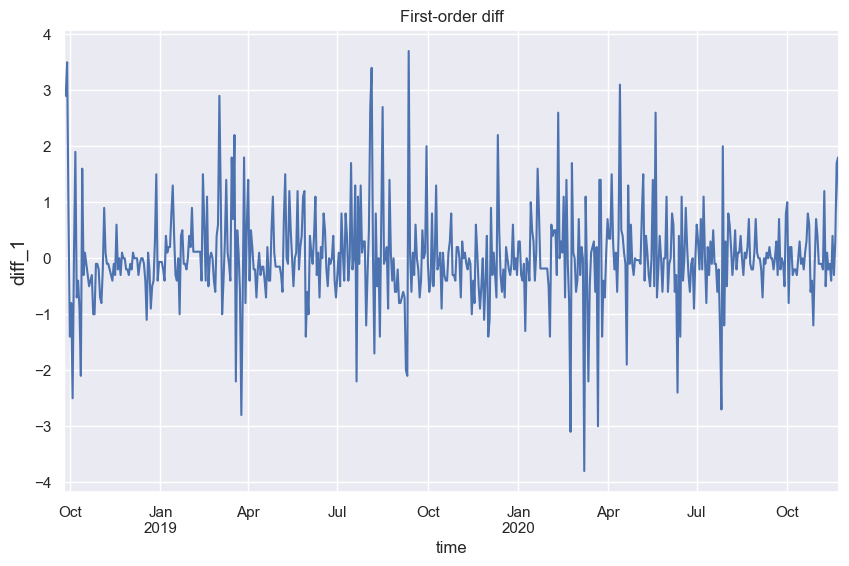

In [57]:
plt.figure(figsize=(10, 6))
# training_set['diff_1'].plot()
train['diff_1'].plot()

plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()




In [58]:
# Second-order diff
# training_set['diff_2'] = training_set['diff_1'].diff(1)
train['diff_2'] = train['diff_1'].diff(1)

# train.dropna(inplace=True)

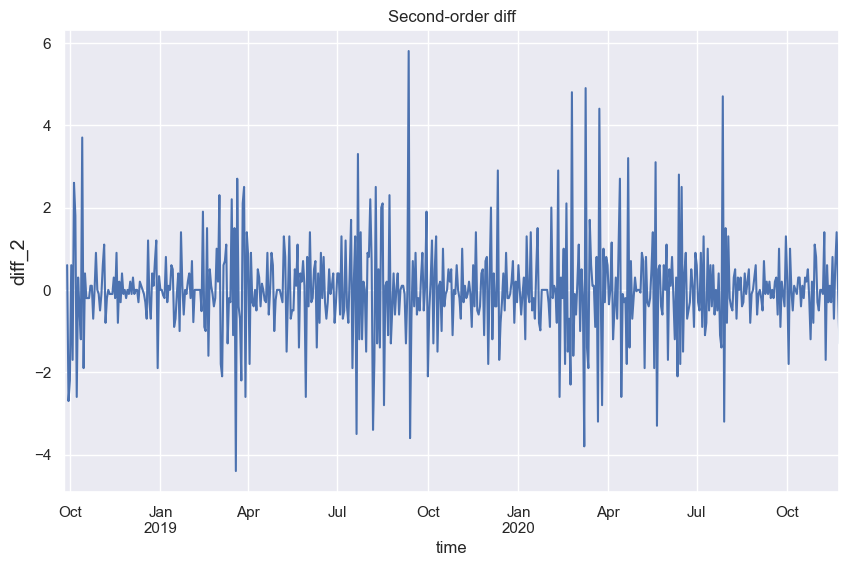

In [59]:
plt.figure(figsize=(10, 6))
# training_set['diff_2'].plot()
train['diff_2'].plot()

plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

In [104]:
temp2 = np.diff(train['close'], n=1)
lag = 10  # Number of lags to consider
lb_test = acorr_ljungbox(temp2, lags=lag)

# For statsmodels >= 0.12, acorr_ljungbox returns a DataFrame
if hasattr(lb_test, 'keys') and 'lb_pvalue' in lb_test:
    p_values = lb_test['lb_pvalue']
else:
    # For older versions, it's a tuple
    p_values = lb_test[1]

for lag_num, p_value in enumerate(p_values, start=1):
    if float(p_value) < 0.05:
        print(f"Lag {lag_num}: p-value = {p_value} (significant autocorrelation)")
    else:
        print(f"Lag {lag_num}: p-value = {p_value} (no significant autocorrelation)")

# all p-value > 0.05, white noise time-series after diff 1

Lag 1: p-value = 0.5483941454792822 (no significant autocorrelation)
Lag 2: p-value = 0.33405390465920043 (no significant autocorrelation)
Lag 3: p-value = 0.3571248257662988 (no significant autocorrelation)
Lag 4: p-value = 0.33834330536632545 (no significant autocorrelation)
Lag 5: p-value = 0.4212017525560898 (no significant autocorrelation)
Lag 6: p-value = 0.49778037184395796 (no significant autocorrelation)
Lag 7: p-value = 0.5909791389036229 (no significant autocorrelation)
Lag 8: p-value = 0.6839289904544297 (no significant autocorrelation)
Lag 9: p-value = 0.7546451814669508 (no significant autocorrelation)
Lag 10: p-value = 0.3240339425463205 (no significant autocorrelation)


In [105]:
def kpss_test(x): # H0: stationary
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [106]:
adf_test(train['close']) # p>0.05, nonstationary

                                value
Test Statistic Value        -1.763296
p-value                       0.39883
Lags Used                           0
Number of Observations Used       565
Critical Value(1%)          -3.441977
Critical Value(5%)          -2.866669
Critical Value(10%)         -2.569502


In [107]:
kpss_test(train['close']) # p-value < 0.05, nonstationary

Test Statistic            1.170115
p-value                   0.010000
# of Lags                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [108]:
adf_test(train['diff_1'].dropna()) # p-value < 0.05, stationary

                                 value
Test Statistic Value        -23.360216
p-value                            0.0
Lags Used                            0
Number of Observations Used        564
Critical Value(1%)           -3.441998
Critical Value(5%)           -2.866678
Critical Value(10%)          -2.569506


In [109]:
kpss_test(train['diff_1'].dropna()) # p-value > 0.05, stationary


Test Statistic           0.063997
p-value                  0.100000
# of Lags                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

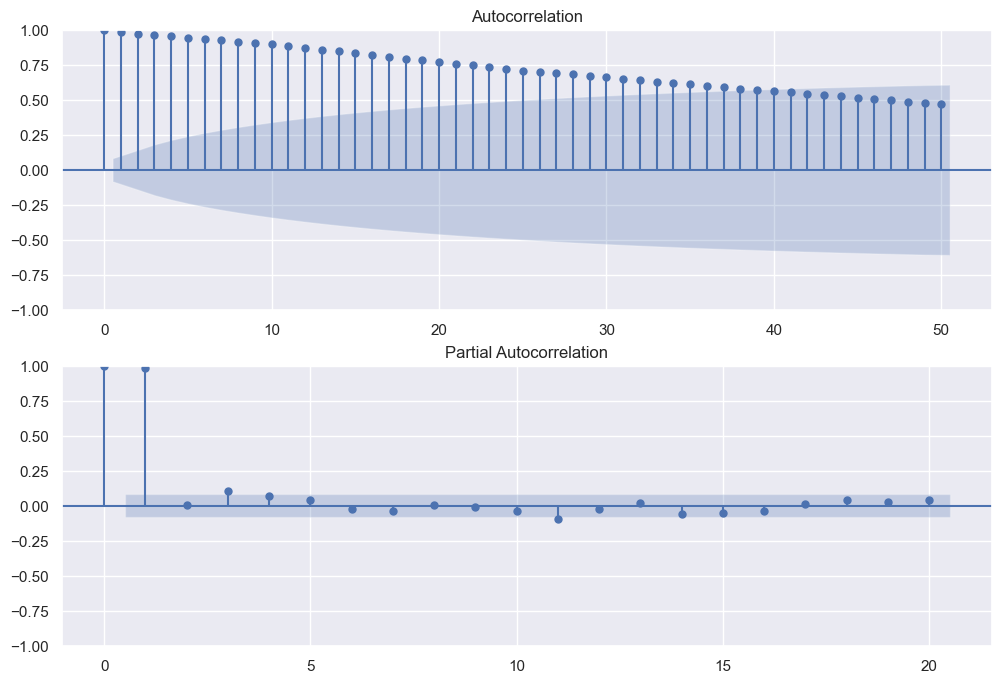

In [110]:

acf_pacf_plot(train['close'],acf_lags=50)




In [111]:
temp1 = np.diff(train['close'], n=1)  # n = 1,  lấy diff 1 lần, auto remove nan value, numpy arr

In [112]:
price = list(temp1)
data2 = {
    'date': train['diff_1'].index[1:],  # start = 1 if 0 is NA
    'close': price
}

&                close
date                
2018-09-26  2.900000
2018-09-27  3.500000
2018-09-28  0.800001
2018-10-01 -1.400002
2018-10-02 -0.799999
...              ...
2020-11-18 -0.299999
2020-11-19  0.299999
2020-11-20  1.700001
2020-11-23  1.799999
2020-11-24  0.500000

[565 rows x 1 columns]


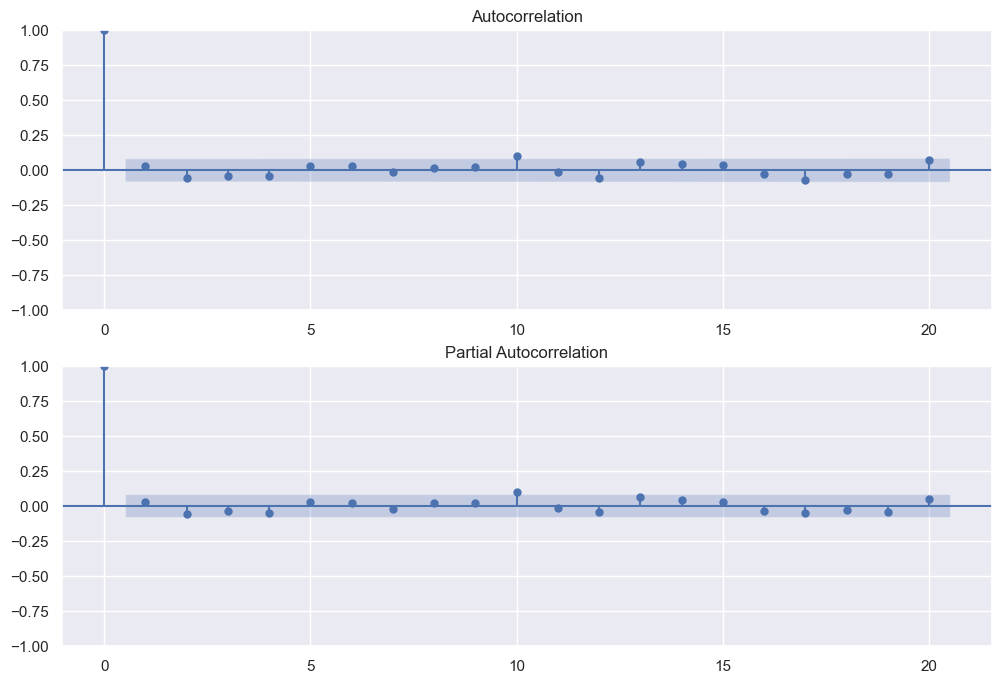

In [113]:
df = pd.DataFrame(data2)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

training_data_diff = df.set_index(['date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)

In [114]:
order_select_ic(training_data_diff=training_data_diff) 
# best ar and ma are (0, 0) return by sm.tsa.arma_order_select_ic(training_data_diff, max_ar=6, max_ma=4, ic='bic') 

0 0


In [115]:
order_select_search(training_set=train) 
# own function return best ar and ma are (0, 0) in range max_p = 5 and max_q = 5

^ 5 ^^ 5
p and q: 0,0
p and q: 0,0


In [116]:
# order=(p,d,q)
model = sm.tsa.ARIMA(endog=train['close'], order=(0, 1, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  566
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -697.193
Date:                Mon, 13 Oct 2025   AIC                           1396.387
Time:                        15:37:01   BIC                           1400.724
Sample:                    09-25-2018   HQIC                          1398.080
                         - 11-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6908      0.023     29.691      0.000       0.645       0.736
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               430.63
Prob(Q):                              0.55   Pr

##ARIMA on Validation

In [117]:
history = [x for x in train['close']]
# print('history', type(history), history)
predictions = list()
# print('test_set.shape', test_set.shape[0])
for t in range(valid.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(0, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = float(yhat[0])
    predictions.append(yhat)
    obs = valid.iloc[t, 0]  # 0 là vị trị của close
    # obs = float(obs)
    # print('obs', type(obs))
    history.append(obs)
    # print(test_set.index[t])
    print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
# print('predictions', predictions)

1 predicted=32.000000, expected=30.700000
2 predicted=30.700000, expected=30.700000
3 predicted=30.700000, expected=31.300000
4 predicted=31.300000, expected=30.900000
5 predicted=30.900000, expected=31.400000
6 predicted=31.400000, expected=32.700000
2 predicted=30.700000, expected=30.700000
3 predicted=30.700000, expected=31.300000
4 predicted=31.300000, expected=30.900000
5 predicted=30.900000, expected=31.400000
6 predicted=31.400000, expected=32.700000
7 predicted=32.700000, expected=32.300000
8 predicted=32.300000, expected=32.100000
7 predicted=32.700000, expected=32.300000
8 predicted=32.300000, expected=32.100000
9 predicted=32.100000, expected=32.500000
9 predicted=32.100000, expected=32.500000
10 predicted=32.500000, expected=32.100000
11 predicted=32.100000, expected=32.200000
12 predicted=32.200000, expected=32.700000
13 predicted=32.700000, expected=33.500000
14 predicted=33.500000, expected=33.500000
15 predicted=33.500000, expected=32.900000
10 predicted=32.500000, expe

In [118]:
evaluation_metric(valid['close'],predictions)
# (0,1,0)
# MSE: 1.05188
# RMSE: 1.02561
# MAE: 0.70380
# R2: 0.94587
# GetMAPE(y_hat, y_test):
mape_validation = GetMAPE(predictions, valid['close'])
print('mape_validation : %.3f' % mape_validation, '%' )


MSE: 1.05103
RMSE: 1.02520
MAE: 0.70123
R2: 0.94592
mape_validation : 1.980 %


## MLflow Tracking: ARIMA Model

In [119]:
# Start MLflow run for ARIMA model
mlflow_arima_run_id = None

with mlflow.start_run(run_name="ARIMA_Model") as run:
    mlflow_arima_run_id = run.info.run_id
    
    # Log parameters
    mlflow.log_param("model_type", "ARIMA")
    mlflow.log_param("p", 0)
    mlflow.log_param("d", 1)
    mlflow.log_param("q", 0)
    mlflow.log_param("order", "(0,1,0)")
    mlflow.log_param("grid_search_ranges", "p=[0-4], d=[0-1], q=[0-4]")
    
    # Calculate validation metrics
    val_mse = metrics.mean_squared_error(valid['close'], predictions)
    val_rmse = np.sqrt(val_mse)
    val_mae = metrics.mean_absolute_error(valid['close'], predictions)
    val_r2 = metrics.r2_score(valid['close'], predictions)
    
    # Log validation metrics
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_r2", val_r2)
    mlflow.log_metric("val_mape", mape_validation)
    
    print(f"✅ ARIMA Model (Validation) logged to MLflow - Run ID: {run.info.run_id}")
    print(f"   Validation RMSE: {val_rmse:.5f}, MAPE: {mape_validation:.3f}%")

✅ ARIMA Model (Validation) logged to MLflow - Run ID: e651dc18d94542839a3b99f0f55017d3
   Validation RMSE: 1.02520, MAPE: 1.980%


In [120]:

predictions1 = {
    # 'trade_date': test_set.index[:],
    'date': valid.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['date'], drop=True)

predictions1

,close
date,
2020-11-25,32.0
2020-11-26,30.7
2020-11-27,30.7
2020-11-30,31.3
2020-12-01,30.9
...,...
2021-10-25,37.5
2021-10-26,36.9
2021-10-27,37.4


In [121]:
predictions1.to_csv('./ARIMA_Validation.csv')

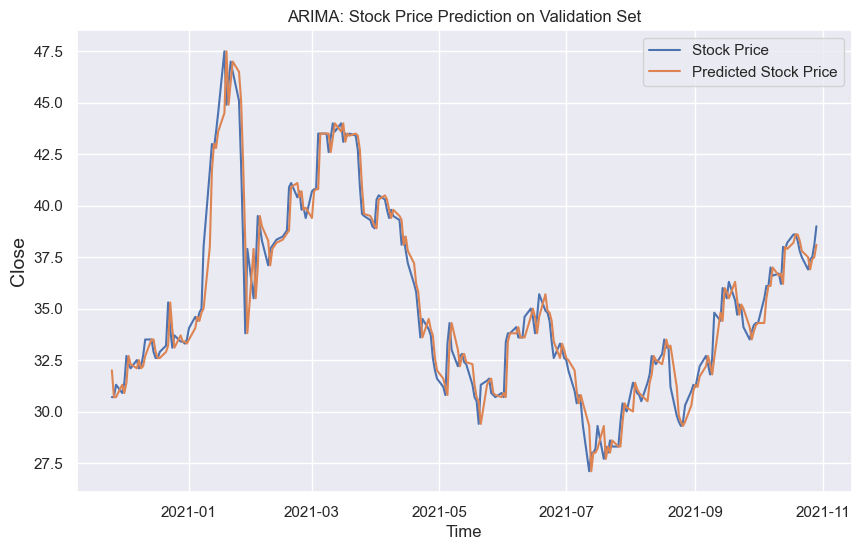

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(valid['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction on Validation Set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

##Extract Residual feature

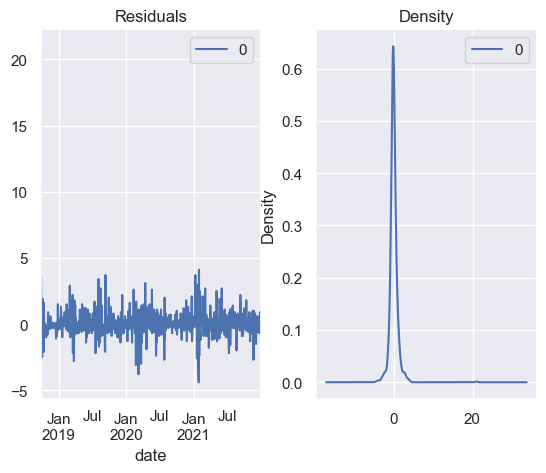

In [123]:

model2 = sm.tsa.ARIMA(endog=d['close'], order=(0, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.subplots_adjust(wspace=0.25)  # Increase the spacing between the subplots

plt.show()

In [124]:
residuals.mean()

0    0.03829
dtype: float64

In [125]:
residuals

,0
date,
2018-09-25,21.0
2018-09-26,2.9
2018-09-27,3.5
2018-09-28,0.8
2018-10-01,-1.4
...,...
2021-12-27,0.9
2021-12-28,-0.5
2021-12-29,-0.1


In [126]:
residuals.to_csv('./ARIMA_residuals1.csv')

##ARIMA on Test set

In [127]:
history2 = [x for x in training_set['close']]
# print('history', type(history), history)
predictions2 = list()
# print('test_set.shape', test_set.shape[0])
for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history2, order=(0, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = float(yhat[0])
    predictions2.append(yhat)
    obs = test_set.iloc[t, 0]  # 0 là vị trị của close
    # obs = np.float(obs)
    # print('obs', type(obs))
    history2.append(obs)
    # print(test_set.index[t])
    print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
# print('predictions', predictions)

1 predicted=39.000000, expected=38.700000
2 predicted=38.700000, expected=38.800000
3 predicted=38.800000, expected=37.500000
4 predicted=37.500000, expected=37.900000
5 predicted=37.900000, expected=37.700000
6 predicted=37.700000, expected=37.700000
7 predicted=37.700000, expected=37.600000
8 predicted=37.600000, expected=37.300000
9 predicted=37.300000, expected=36.600000
10 predicted=36.600000, expected=36.400000
11 predicted=36.400000, expected=37.200000
12 predicted=37.200000, expected=36.700000
13 predicted=36.700000, expected=37.700000
14 predicted=37.700000, expected=37.400000
15 predicted=37.400000, expected=36.300000
8 predicted=37.600000, expected=37.300000
9 predicted=37.300000, expected=36.600000
10 predicted=36.600000, expected=36.400000
11 predicted=36.400000, expected=37.200000
12 predicted=37.200000, expected=36.700000
13 predicted=36.700000, expected=37.700000
14 predicted=37.700000, expected=37.400000
15 predicted=37.400000, expected=36.300000
16 predicted=36.300000

In [128]:
evaluation_metric(test_set['close'],predictions2)
# (0, 1, 0)
# MSE: 0.53154
# RMSE: 0.72907
# MAE: 0.51793
# R2: 0.89888
# GetMAPE(y_hat, y_test):
mape_test = GetMAPE(predictions2, test_set['close'])
print('mape_test : %.3f' % mape_test, '%' )

MSE: 0.52556
RMSE: 0.72495
MAE: 0.51333
R2: 0.90002
mape_test : 1.497 %


In [131]:
# Continue ARIMA MLflow run with test metrics and save artifacts
predictions2_df = pd.DataFrame({'date': test_set.index, 'close': predictions2})
predictions2_df = predictions2_df.set_index('date', drop=True)
predictions2_df.to_csv('ARIMA.csv')  # Ensure ARIMA.csv is saved before logging
with mlflow.start_run(run_id=mlflow_arima_run_id) as run:
    
    # Calculate test metrics
    test_mse = metrics.mean_squared_error(test_set['close'], predictions2)
    test_rmse = np.sqrt(test_mse)
    test_mae = metrics.mean_absolute_error(test_set['close'], predictions2)
    test_r2 = metrics.r2_score(test_set['close'], predictions2)
    
    # Log test metrics
    mlflow.log_metric("test_mse", test_mse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)
    mlflow.log_metric("test_mape", mape_test)
    
    # Save and log ARIMA model
    mlflow.log_artifact("model_ARIMA.pkl", artifact_path="model")
    
    # Log residuals and predictions as artifacts
    mlflow.log_artifact("ARIMA_residuals1.csv", artifact_path="residuals")
    mlflow.log_artifact("ARIMA_Validation.csv", artifact_path="predictions")
    mlflow.log_artifact("ARIMA.csv", artifact_path="predictions")
    
    print(f"✅ ARIMA Model (Test) logged to MLflow - Run ID: {run.info.run_id}")
    print(f"   Test RMSE: {test_rmse:.5f}, MAPE: {mape_test:.3f}%")
    print(f"   Artifacts: model, residuals, predictions saved")

✅ ARIMA Model (Test) logged to MLflow - Run ID: e651dc18d94542839a3b99f0f55017d3
   Test RMSE: 0.72495, MAPE: 1.497%
   Artifacts: model, residuals, predictions saved


In [132]:
predictions2 = {
    # 'trade_date': test_set.index[:],
    'date': test_set.index[:],
    'close': predictions2
}
predictions2 = pd.DataFrame(predictions2)
predictions2 = predictions2.set_index(['date'], drop=True)
predictions2

,close
date,
2021-11-01,39.0
2021-11-02,38.7
2021-11-03,38.8
2021-11-04,37.5
2021-11-05,37.9
2021-11-08,37.7
2021-11-09,37.7
2021-11-10,37.6
2021-11-11,37.3


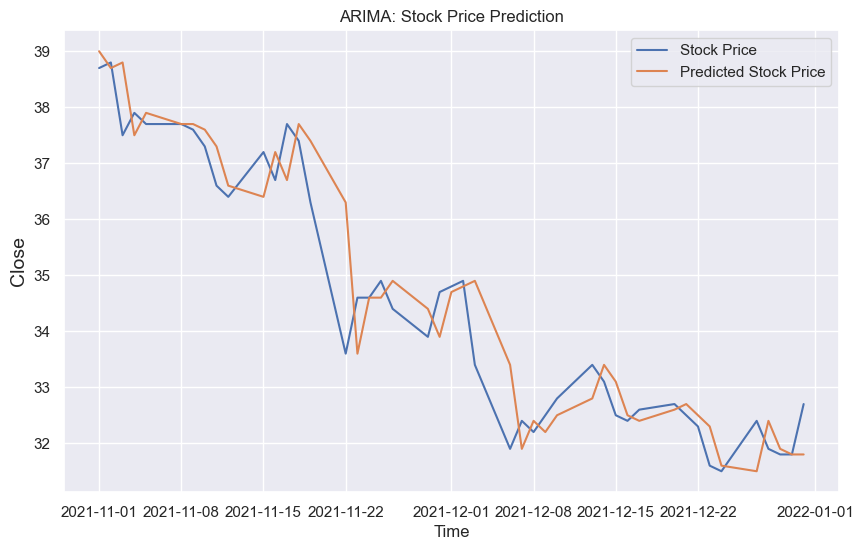

In [133]:

plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions2, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [134]:
# Save predictions value on Test
predictions2.to_csv('./ARIMA.csv')

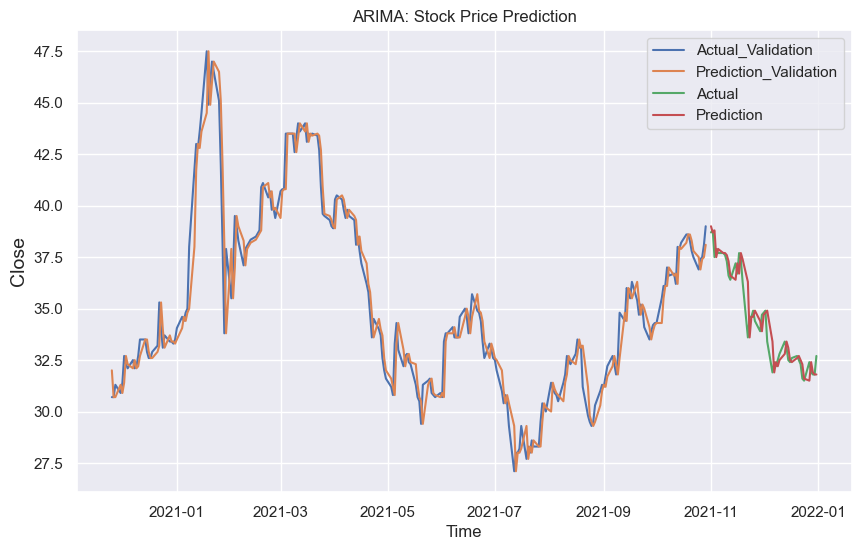

In [135]:
plt.figure(figsize=(10, 6))
# Plot the predictions and actual values on the validation set
# plt.plot(train.index, train['close'], label='train_set')


plt.plot(valid.index, valid['close'], label='Actual_Validation')
plt.plot(predictions1.index, predictions1['close'], label='Prediction_Validation')

# Plot the predictions and actual values on the test set
plt.plot(test_set.index, test_set['close'], label='Actual')
plt.plot(predictions2.index, predictions2['close'], label='Prediction')

# Customize the plot

plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Display the plot
plt.show()
